In [1]:
from utils import *
from speedup import *

In [2]:
with open("/v/volumes/nanopore/ref/p300_ID3.fasta", 'r') as file:
    p300_ID3_ref = file.read().split('\n')[1]
p300_ID3_ref = np.array(list(p300_ID3_ref))

# Thymine reverse strands

In [3]:
T_sam_data = read_sam(sorted(glob("/v/projects/nanopore/balazs/data/thymine_0421/*0.sam"))[:2],
                      min_length=len(p300_ID3_ref)*0.8,
                      max_length=len(p300_ID3_ref)*1.2, 
                      min_MAPQ=60,
                      max_insertion=7, # connected sequence
                      max_deletion=7, # connected sequence
                      max_indel_frequency=0.4,
                      verbose=True
                     )
path_to_Thymine_fast5 = '/v/projects/nanopore/agnes/signal_visualization/data/timin0421/workspace/'


Loading data: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]

Number of reads stored: 4887


In [15]:
T_reverse_strands = search_in_data(T_sam_data, "sam_flag", 16, only_first_match=False)[:1000]
thymine_rvs_strd = get_raw_signal_with_bases(T_reverse_strands, path_to_Thymine_fast5, reference_sequence=p300_ID3_ref)


Processing data: 100%|██████████| 1000/1000 [00:28<00:00, 35.26it/s]


# Uracil reverse strands

In [5]:
np.random.seed(137) # there are too much files
read_paths = np.random.choice(glob("/v/projects/nanopore/balazs/data/uracil_0504/*0.sam"), 2)
U_sam_data = read_sam(sorted(read_paths),
                      min_length=len(p300_ID3_ref)*0.8,
                      max_length=len(p300_ID3_ref)*1.2, 
                      min_MAPQ=60,
                      max_insertion=4, # connected sequence
                      max_deletion=4, # connected sequence
                      max_indel_frequency=0.1,
                      verbose=True
                     )
path_to_Uracil_fast5 = '/v/projects/nanopore/agnes/signal_visualization/uracil0504/guppy/workspace/'

Loading data: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

Number of reads stored: 2828


In [12]:
U_reverse_strands = search_in_data(U_sam_data, "sam_flag", 16, only_first_match=False)[:1000]
uracil_rvs_strd = get_raw_signal_with_bases(U_reverse_strands, path_to_Uracil_fast5, reference_sequence=p300_ID3_ref)

Processing data: 100%|██████████| 1000/1000 [00:54<00:00, 18.29it/s]


In [13]:
searched_position = find_loneliest_bases_in_seq(p300_ID3_ref, only_nth=1)
searched_position 

657

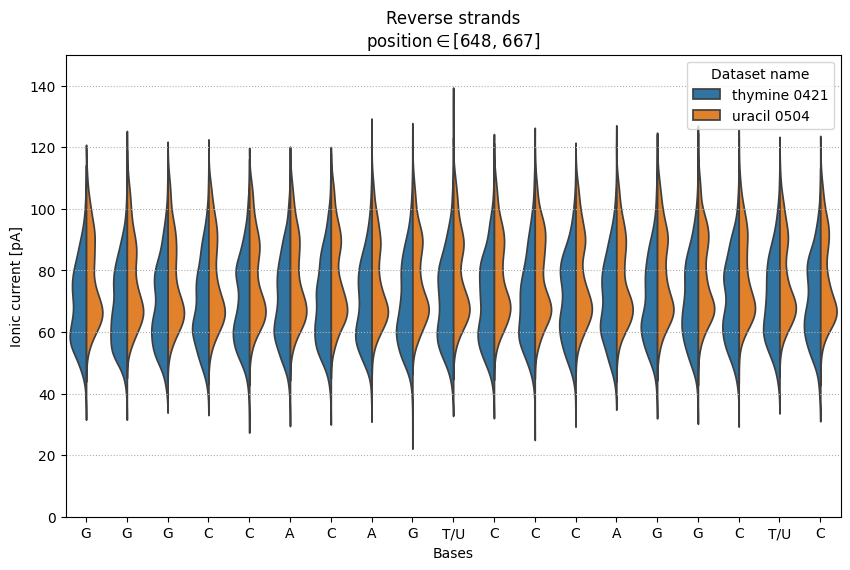

In [16]:
N_left, N_right = 9, 9 # number of left and right neighbors

data_T_rvs = create_df_to_violin_plot(thymine_rvs_strd, 'thymine 0421',
                                      N_left, N_right, searched_position)
data_U_rvs = create_df_to_violin_plot(uracil_rvs_strd, 'uracil 0504',
                                      N_left, N_right, searched_position)

rvs_violin_df = pd.concat([data_T_rvs, data_U_rvs], ignore_index=True)

plt.figure(figsize=(10, 6))
plt.grid(ls='dotted', axis='y')
sns.violinplot(data=rvs_violin_df, x="Bases", y="IonicCurrent", hue="Dataset name", split=True, density_norm="width", inner=None)
plt.xlabel("Bases")
plt.ylabel("Ionic current [pA]")
plt.title("Reverse strands\nposition"+r"$\in$"+f"[{searched_position-N_left}, {searched_position+N_right+1}]")
labels = p300_ID3_ref[searched_position - N_left: searched_position + N_right + 1]
plt.xticks(ticks=np.arange(N_left+N_right+1), labels=np.where(labels=='T', 'T/U', labels))
plt.ylim(0, 150)
plt.savefig(f'figures/rvs_example.jpg', bbox_inches='tight')
plt.show()